In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

from IPython.display import display
import sympy; sympy.init_printing()
import random

def display_matrix(m):
    display(sympy.Matrix(m))

**Numerical Solution**


In [2]:
r = 0.13; sig = 0.05                
S0 = 100; X0 = np.log(S0)          
K = 150; Texpir = 1
Nspace = 100   # M space steps
Ntime = 100    # N time steps   

S_max = 2*float(K)                
S_min = float(K)/2

x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1
    
x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)   # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)       # time discretization


In [3]:
def Implicit(r , sig , S0 ,X0 , K , Texpir):
    Nspace = 100   # M space steps
    Ntime = 100    # N time steps   

    S_max = 2*float(K)                
    S_min = float(K)/2

    x_max = np.log(S_max)  # A2
    x_min = np.log(S_min)  # A1
    
    x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)   # space discretization
    T, dt = np.linspace(0, Texpir, Ntime, retstep=True)       # time discretization
    Payoff = np.maximum(np.exp(x)-K,0)          # Call payoff
    V = np.zeros((Nspace,Ntime))       # grid initialization
    offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

    V[:,-1] = Payoff                   # terminal conditions 
    V[-1,:] = np.exp(x_max) - K * np.exp(-r* T[::-1] )  # boundary condition
    V[0,:] = 0                         # boundary condition
    
    sig2 = sig*sig; dxx = dx * dx

    a = ( (dt/2) * ( (r-0.5*sig2)/dx - sig2/dxx ) )
    b = ( 1 + dt * ( sig2/dxx + r ) )
    c = (-(dt/2) * ( (r-0.5*sig2)/dx + sig2/dxx ) )

    D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
    
    # Backward iteration
    for i in range(Ntime-2,-1,-1):
        offset[0] = a * V[0,i]
        offset[-1] = c * V[-1,i]; 
        V[1:-1,i] = spsolve( D, (V[1:-1,i+1] - offset) )
        
    # finds the option at S0
    oPrice = np.interp(X0, x, V[:,0])
    S = np.exp(x)
    fig = plt.figure(figsize=(15,6))
    ax2 = fig.add_subplot(122, projection='3d')


    X, Y = np.meshgrid(T, S)
    ax2.plot_surface(Y, X, V, cmap=cm.ocean)
    ax2.set_title("BS price surface(Numerical)")
    ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
    ax2.view_init(30, 130) # this function rotates the 3d plot
    plt.show()
    return oPrice , V    

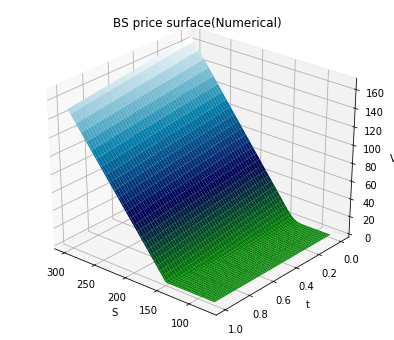

In [4]:
#for i in range(len(Texpir)):
    
C,V = Implicit(r , sig , S0 ,X0 , K , Texpir)

Benchmark using Numerical Scheme

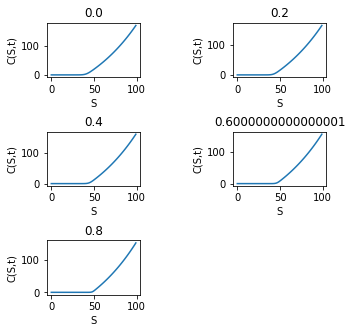

In [34]:
fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(hspace=1, wspace=1)
K = np.arange(0,100,20)
T = np.arange(0, 1.2, 0.2)
for i in range(len(K)):
    plt.subplot(3, 2, i+1)
    plt.plot(V[:,K[i]])
    plt.xlabel('S')
    plt.ylabel('C(S,t)')
    plt.title(T[i])
    #plt.show()
    

**Analytical Solution**

In [37]:
from scipy.stats import norm


r = 0.13
S = 200
K = 150
T1 = 1
sigma = 0.05

def blackscholes(r,S,K,T,sigma,type="C"):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    try:
        if type == "C":
            price = S*norm.cdf(d1,0,1)- K*np.exp(-r*T)*norm.cdf(d2,0,1)
        elif type == "P":
            price = K * np.exp(-r*T)*norm.cdf(-d2,0,1) - S*norm.cdf(-d1,0,1)
        return price
    except:
        print("Confirm Parameters")
print('Option price is',blackscholes(r,S,K,T1,sigma,type="C"))  

Option price is 68.2856853619158


**Benchmarks using Analytical method**

In [79]:
def timestep(T):
    S1 = np.exp(x)
    U_0_new = []
    
    for i in range(len(S1)):
        U_0_new.append(blackscholes(0.13,S1[i],150,T,0.05,type="C"))
    U_0_new = np.array(U_0_new)
    #plt.show()
    return U_0_new

C:\Users\affan\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


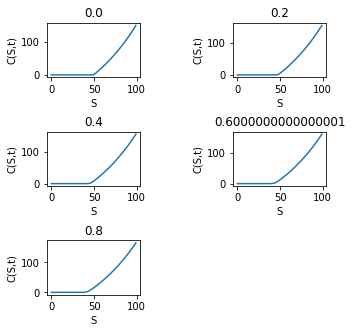

In [87]:
U_new = []
T = np.arange(0, 1, 0.2)
for i in range(len(T)):
    U_new.append(timestep(T[i]))
    
fig = plt.figure(figsize=(5,5))
fig.subplots_adjust(hspace=1, wspace=1)    
for i in range(5):    
    plt.subplot(3, 2, i+1)
    plt.plot (U_new[i])
    plt.xlabel('S')
    plt.ylabel('C(S,t)')
    plt.title(T[i])


**Variation of Parameters**

C:\Users\affan\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


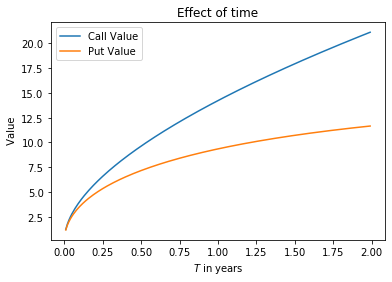

In [98]:
'Effect of time on BS'
K = 100
r = 0.05
T = np.arange(0, 2, 0.01)
sigma = 0.3
S = 100

calls = [blackscholes(r,S,K,t,sigma,type="C") for t in T]
puts = [blackscholes(r,S,K,t,sigma,type="P") for t in T]
plt.plot(T, calls, label='Call Value')
plt.plot(T, puts, label='Put Value')
plt.xlabel('$T$ in years')
plt.ylabel(' Value')
plt.title('Effect of time')
plt.legend()
plt.show()

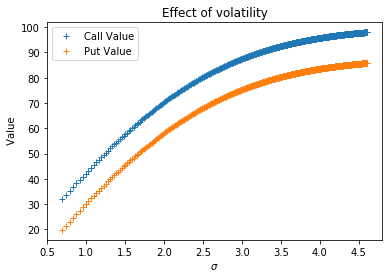

In [97]:
'Effect of volatility on BS'

r = 0.13
S = 100
K = 100
T = 1
t = np.arange(2, 100, 0.1)

Sigmas = np.log(t)

calls = [blackscholes(r,S,K,T,sig,type="C") for sig in Sigmas]
puts = [blackscholes(r,S,K,T,sig,type="P") for sig in Sigmas]
plt.plot(Sigmas, calls,'+' ,label='Call Value')
plt.plot(Sigmas, puts, '+',label='Put Value')
plt.xlabel('$\sigma$')
plt.ylabel(' Value')
plt.title('Effect of volatility')
plt.legend()
plt.show()